In [1]:
import os
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [4]:
label_encoder = preprocessing.OneHotEncoder(sparse_output=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1, 1)).toarray()

In [ ]:
asteroids_oh_y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], shape=(1339, 4))

In [ ]:
# Manual One-Hot_Encode (not really needed)

oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One Hot Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One Hot Vector [1, 0, 0, 0] corresponds to the Main Group: C
One Hot Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One Hot Vector [0, 0, 1, 0] corresponds to the Main Group: S
One Hot Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [8]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [9]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    # Normalizsation layer (like the scikit-learn StandardScaler)
    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs,))

    hidden_layer = normalizer(input_layer)
    
    hidden_layer = keras.layers.Dense(25)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    hidden_layer = keras.layers.Dense(10)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.25,
                    sample_weight=sample_weight)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 49)             │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653 (6.46 KB)

 Trainable params: 1,554 (6.07 KB)

 Non-trainable params: 99 (400.00 B)

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6510 - val_loss: 0.5609
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5403 - val_loss: 0.4852
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4685 - val_loss: 0.4360
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4161 - val_loss: 0.3923
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3647 - val_loss: 0.3424
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3224 - val_loss: 0.3207
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2926 - val_loss: 0.2958
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2720 - val_loss: 0.2770
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2561 - val_loss: 0.2700
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2445 - val_loss: 0.2701
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2360 - val_loss: 0.2544
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [10]:
print(f"'Last' batch size: {len(X_train) % batch_size}")

'Last' batch size: 15


Text(0, 0.5, 'Loss')

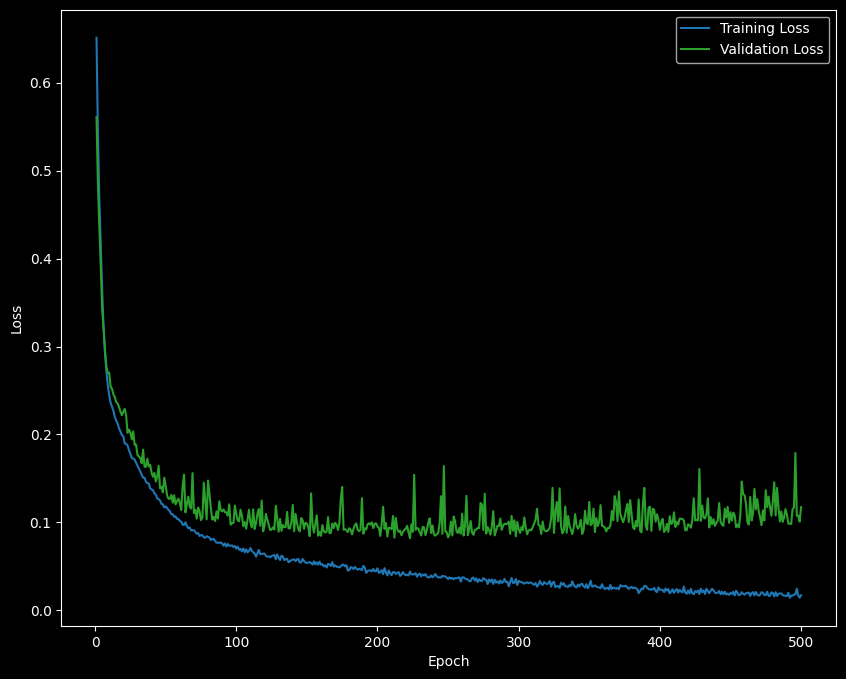

In [11]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [12]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 49)             │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653 (6.46 KB)

 Trainable params: 1,554 (6.07 KB)

 Non-trainable params: 99 (400.00 B)

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9692 - val_loss: 0.6176
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5665 - val_loss: 0.4986
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4748 - val_loss: 0.4304
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4059 - val_loss: 0.3719
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3560 - val_loss: 0.3384
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3213 - val_loss: 0.3103
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2938 - val_loss: 0.3027
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2811 - val_loss: 0.2785
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2628 - val_loss: 0.2660
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2537 - val_loss: 0.2659
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2415 - val_loss: 0.2474
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [13]:
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[2.9336918e-05 6.5440901e-02 9.2934275e-01 5.1870150e-03]
 [9.9993432e-01 2.5944935e-11 1.0241095e-12 6.5644293e-05]
 [5.1742838e-05 7.5537330e-01 1.6846298e-03 2.4289027e-01]
 ...
 [9.8702505e-05 5.9461210e-02 9.2945540e-01 1.0984741e-02]
 [2.6544858e-10 9.9716848e-01 3.4267382e-06 2.8281277e-03]
 [4.4679982e-06 2.0519041e-03 2.2154509e-06 9.9794143e-01]]


In [14]:
# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [15]:
# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

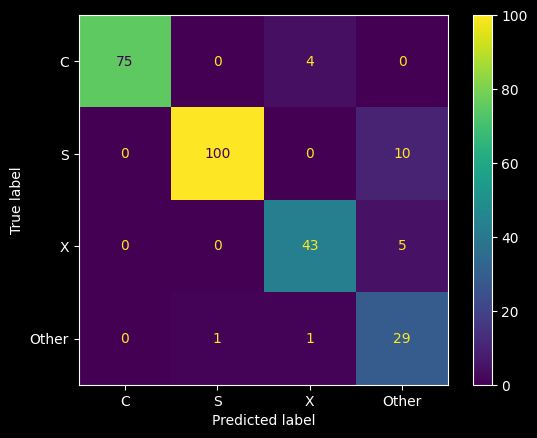

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [17]:
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.926
